In [1]:
# required imports
import os, sys, datetime

os.environ["CUDA_VISIBLE_DEVICES"]="2"

import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import autogluon as ag
from autogluon.tabular import TabularPredictor
import autogluon.eda.auto as auto

import sklearn
from sklearn.metrics import mean_absolute_percentage_error

import shap

shap.initjs()



In [2]:
# VARIABLES / Setup
_SEED = 42
expTimeStamp = datetime.datetime.today().replace(microsecond=0).strftime('%Y%m%d_%H-%M-%S')
OUTPUT_DIR = Path('.') / 'output' / expTimeStamp
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

### Load some dummy data to showcase

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# load california housing dataset
housing = sklearn.datasets.fetch_california_housing(as_frame=True)
df_data = housing.frame
target_col = housing.target.name    # 'MedHouseVal'

# df_train = pd.read_csv('https://autogluon.s3.amazonaws.com/datasets/titanic/train.csv')
# df_test = pd.read_csv('https://autogluon.s3.amazonaws.com/datasets/titanic/test.csv')
# target_col = 'Survived'


display(df_data)
print(df_data.describe())

# split data into train and test
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=_SEED)
print(df_train.shape, df_test.shape)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [4]:
# we need to do some preprocessing to be able to use all the XAI methods
# 1. drop the nan values
# 2. create subset DFs without the label column
# 3. identify categorical and numerical columns

for col in df_train.columns:
    if col == target_col:
        df_train.dropna(subset=col, inplace=True)
    if df_train[col].isnull().sum() > 0 or df_test[col].isnull().sum() > 0:
        print(f'Filling missing values of column {col}')
        if df_train[col].isnull().sum() > 0:
            df_train[col].fillna(df_train[col].mean(), inplace=True)
        if df_test[col].isnull().sum() > 0:
            df_test[col].fillna(df_train[col].mean(), inplace=True)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

numerical_feats = []
categorical_feats = []
for i,v in zip(X_test.dtypes.index,X_test.dtypes.values):
    if v in ('category','bool'):
        categorical_feats.append(i)
    else:
        numerical_feats.append(i)
print("Numerical Features:", numerical_feats)
print("Categorical Features:", categorical_feats)

Numerical Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Categorical Features: []


In [5]:
# fit a dummy SVR
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sk_model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
sk_model.fit(X_train, y_train)

# predict
y_pred_sk = sk_model.predict(X_test)

# evaluate
mape = mean_absolute_percentage_error(y_test, y_pred_sk)
print(f'SK-Learn MAPE: {mape}')

SK-Learn MAPE: 0.22094987970550825


In [6]:
# fit a dummy autogluon model

# define the task
ag_model = TabularPredictor(label=target_col, eval_metric='mean_absolute_error', path=OUTPUT_DIR / 'ag_model', verbosity=2)

# fit a dummy model
ag_model.fit(train_data=df_train,
            auto_stack=True, 
            presets='medium_quality',
            time_limit=40)

# predict
y_pred_ag = ag_model.predict(X_test)

# evaluate
# ag_model.evaluate(df_test, silent=True)
mape = mean_absolute_percentage_error(y_test, y_pred_ag)
print(f'AutoGluon MAPE: {mape}')
ag_model.leaderboard(df_test, silent=True)

Presets specified: ['medium_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 40s
AutoGluon will save models to "output/20231006_16-26-52/ag_model/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #154-Ubuntu SMP Thu Jan 5 17:03:22 UTC 2023
Disk Space Avail:   813.44 GB / 1887.51 GB (43.1%)
Train Data Rows:    16512
Train Data Columns: 8
Label Column: MedHouseVal
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.00001, 0.14999, 2.07195, 1.15623)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Gen

AutoGluon MAPE: 0.15877830178127836


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,-0.276369,-0.287686,0.980175,1.426926,20.051134,0.027333,0.026389,1.204268,2,True,8
1,LightGBM_BAG_L1,-0.276413,-0.291584,0.214050,0.171490,5.059448,0.214050,0.171490,5.059448,1,True,4
2,WeightedEnsemble_L3,-0.276753,-0.285477,1.442492,3.063491,26.076960,0.003481,0.000406,0.188055,3,True,12
3,CatBoost_BAG_L2,-0.277790,-0.286107,0.984045,1.442167,21.649553,0.031204,0.041630,2.802686,2,True,10
4,LightGBMXT_BAG_L2,-0.278926,-0.289165,1.001756,1.436137,20.172070,0.048914,0.035601,1.325204,2,True,7
5,WeightedEnsemble_L2,-0.279503,-0.289237,0.909848,1.281876,18.972959,0.002652,0.000477,0.191497,2,True,6
6,RandomForestMSE_BAG_L2,-0.280499,-0.292876,1.136465,2.200566,20.021350,0.183623,0.800030,1.174484,2,True,9
7,ExtraTreesMSE_BAG_L2,-0.280714,-0.290354,1.147936,2.159435,19.382262,0.195095,0.758899,0.535396,2,True,11
8,LightGBMXT_BAG_L1,-0.300964,-0.310316,0.511830,0.406831,12.960681,0.511830,0.406831,12.960681,1,True,3
9,RandomForestMSE_BAG_L1,-0.324903,-0.326782,0.181316,0.703077,0.761333,0.181316,0.703077,0.761333,1,True,5


#### EDA (Exploratory Data Analysis) with AutoGluon

using autogluon built-ins from the eda module \
(will automatically preprocess the data, but it doesn’t fill in missing numeric values by default)

Note that the dataset (just for demonstration) is in nice quality, so we do not detect anything here. \
Test with your own data

In [7]:
auto.covariate_shift_detection(train_data=df_train, test_data=df_test, label=target_col)

We did not detect a substantial difference between the training and test X distributions.

In [8]:
#NOTE: theres a bug in the detect_anomalies function for now - we cannot use it as is
state = auto.detect_anomalies(
    train_data=df_train,
    test_data=df_test,
    label=target_col,
    threshold_stds=3,    #how many standard deviations above mean anomaly score are considered to be anomalies (only needed for visualization, does not affect scores calculation)
    show_top_n_anomalies=5,
    explain_top_n_anomalies=1,
    return_state=True,
    show_help_text=False,
    fig_args={
        'figsize': (6, 4)
    },
    chart_args={
        'normal.color': 'lightgrey',
        'anomaly.color': 'orange',
    }    
)

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

### Missing Values Analysis

,missing_count,missing_ratio


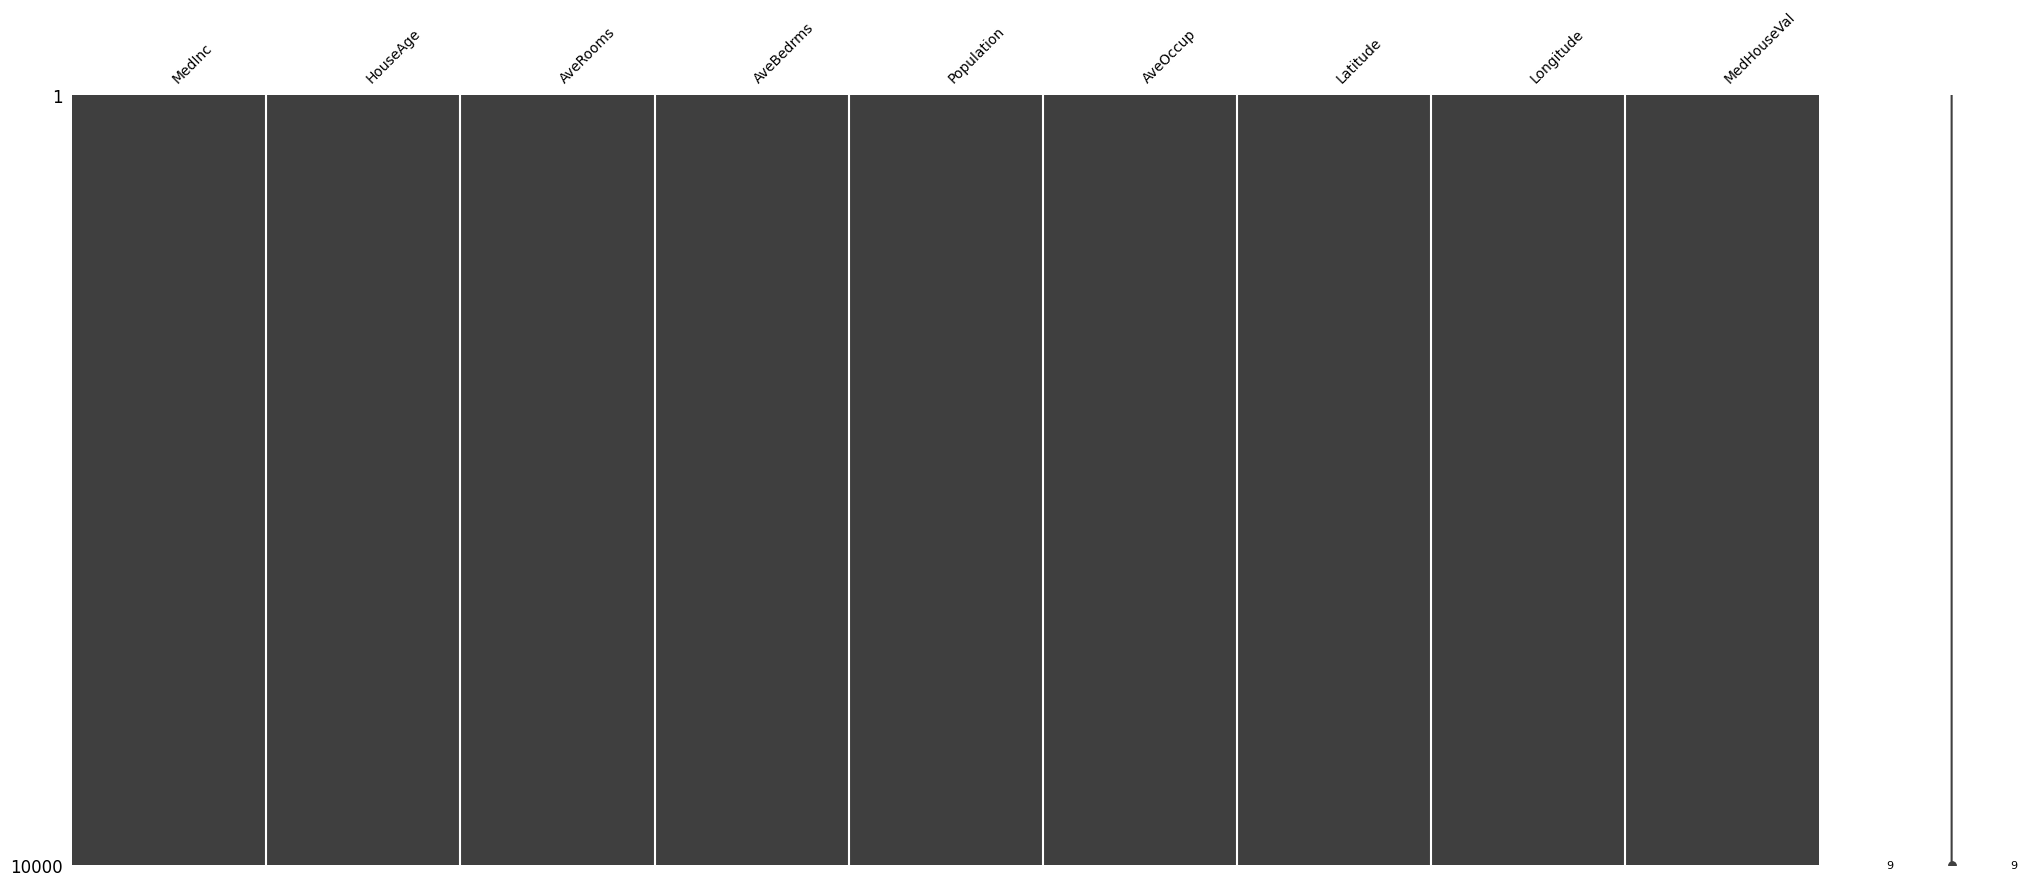

In [9]:
# Autogluon feature interaction
auto.missing_values_analysis(train_data=df_train)

### Permutation feature importance

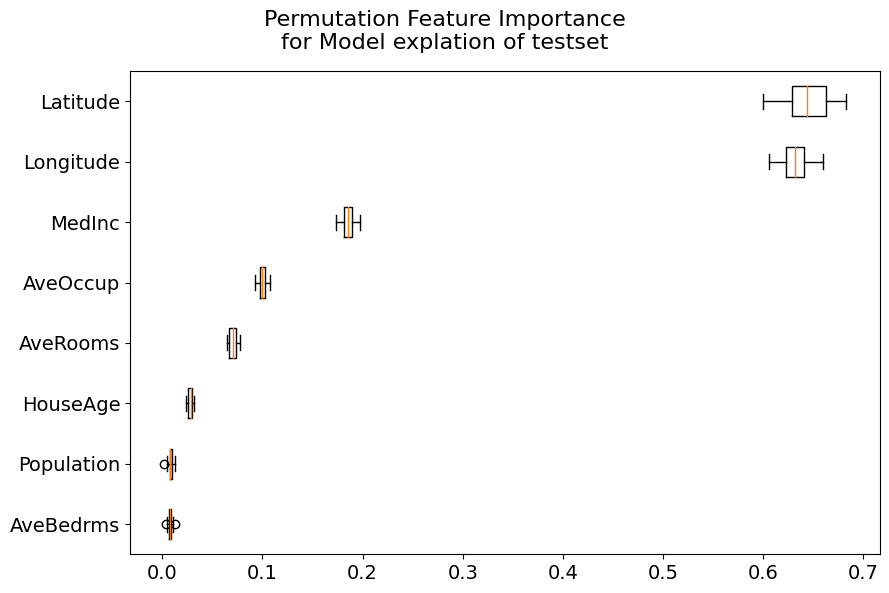

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    ag_model, X_test, y_test,
    n_repeats=20, max_samples=1.0, #maybe required as trade-off bc dataset is huge
    scoring='neg_mean_absolute_error',   #None uses the model default scorer
    random_state=_SEED, n_jobs=64,
)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_test.columns[i] for i in sort_idx], vert=False)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(14)
fig.suptitle(
    "Permutation Feature Importance\n"
    "for Model explation of testset",
    fontsize=16,
)
fig.tight_layout()
fig.savefig(str(OUTPUT_DIR / f"Permutation-FI.png"), bbox_inches = 'tight', dpi=150)
plt.show()

### Partial dependency and individual conditional expectation plots

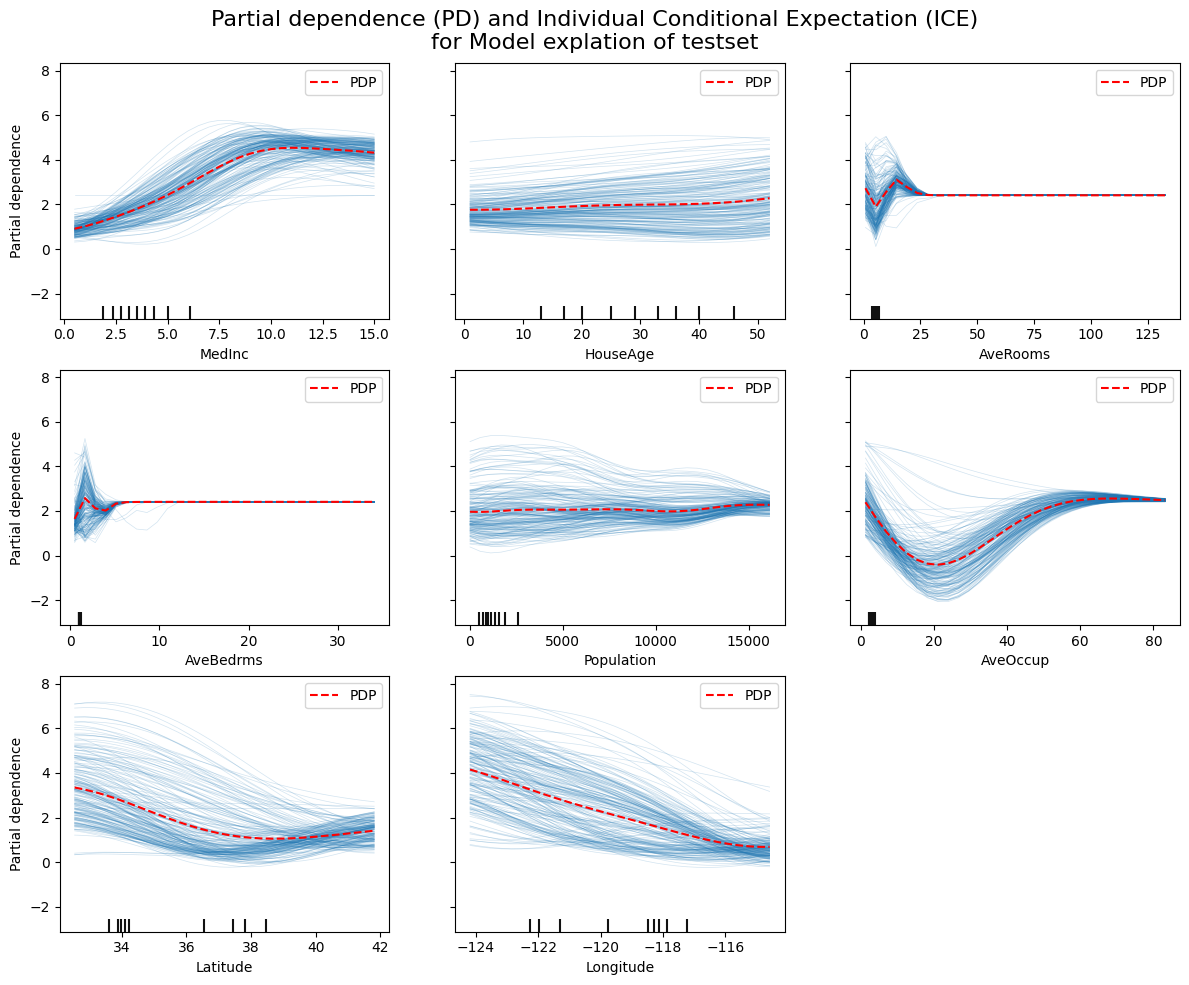

In [ ]:
# This only works fpr sklearn models!
from sklearn.inspection import PartialDependenceDisplay
import math

pd_line_kw = {'color':'red','label':'PDP'}
ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5}

features = numerical_feats   #features to plot
ncols=3
nrows=math.ceil(len(features)/ncols)
fig = plt.figure(figsize=(4*ncols, 3*nrows+1), constrained_layout=True)
ax = fig.add_subplot(111)
display = PartialDependenceDisplay.from_estimator(
    sk_model, X_test, features=features, subsample=200, percentiles=(0, 1),
    grid_resolution=30, kind="both", n_jobs=64, ax=ax,
    pd_line_kw=pd_line_kw, ice_lines_kw=ice_lines_kw,
    )
_ = display.figure_.suptitle(
    "Partial dependence (PD) and Individual Conditional Expectation (ICE)\n"
    "for Model explation of testset",
    fontsize=16,
)
plt.tight_layout()
fig.savefig(str(OUTPUT_DIR / f"SK-Model_PDP_ICE.png"), bbox_inches = 'tight', dpi=150)
plt.show()

### Partial Dependence Plots

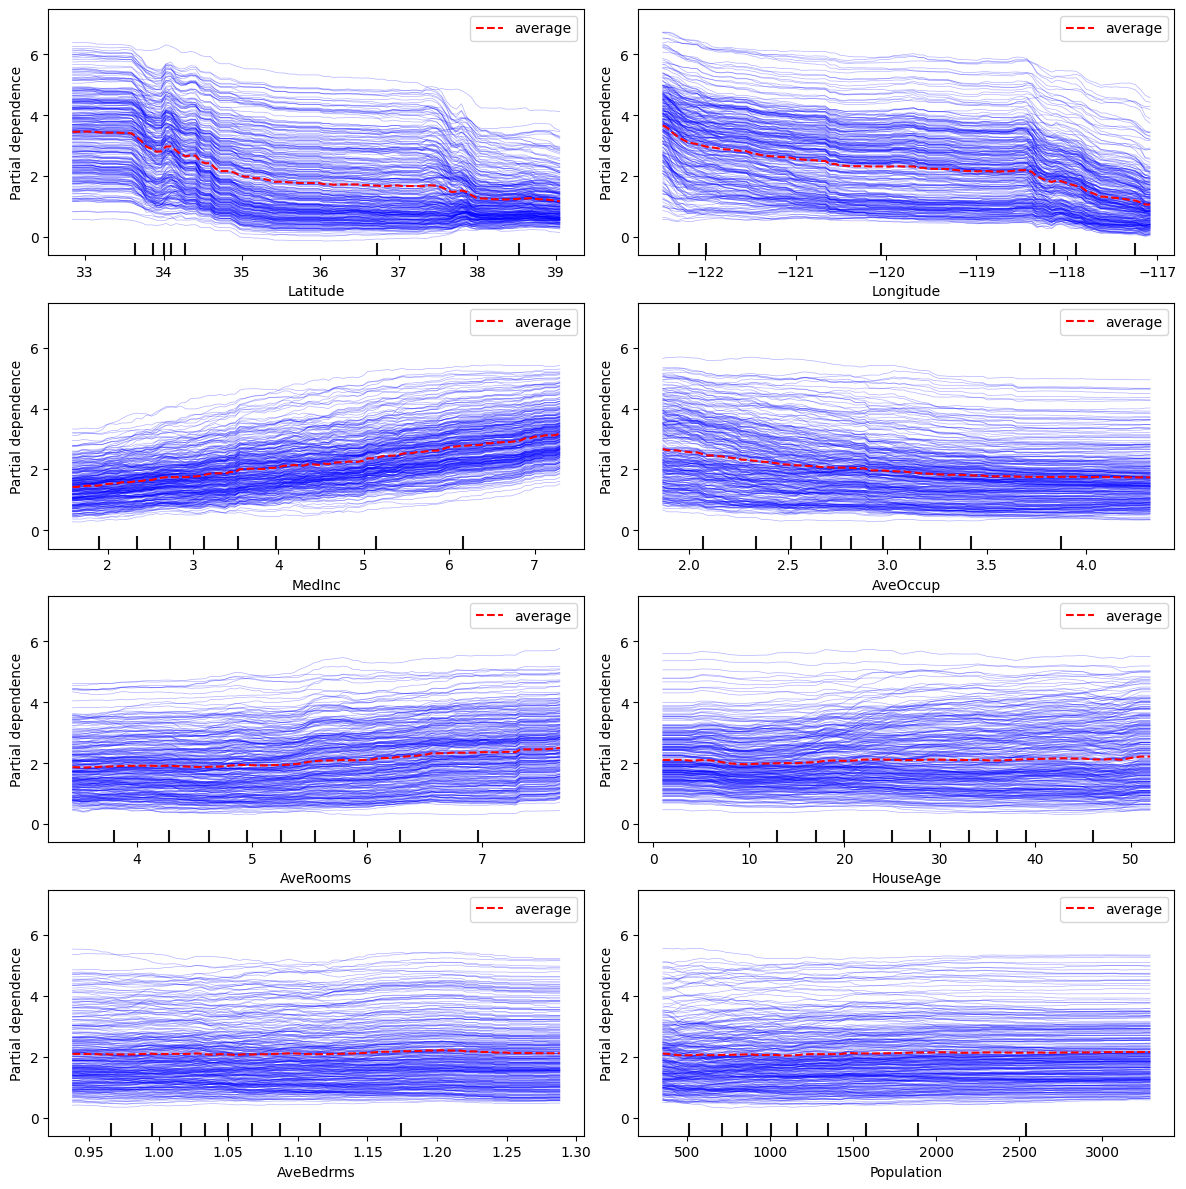

<Figure size 640x480 with 0 Axes>

In [20]:
import autogluon.eda.auto as auto
state = auto.partial_dependence_plots(df_train, label=target_col, return_state=True, path=OUTPUT_DIR / 'ag_eda', show_help_text=False)
fig = plt.gcf()
fig.savefig(str(OUTPUT_DIR / f"AG-Model_PDP_ICE.png"), bbox_inches = 'tight', dpi=150)

## SHAP with AutoGluon starts here

In [7]:
# AGL Wrapper to use SHAP explanations
class AutogluonWrapper:
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        if target_class is None and predictor.problem_type != 'regression':
            print("Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        if self.ag_model.problem_type == "regression" or self.target_class is None:
            return preds
        else:
            return preds[self.target_class]
        
    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

AutoGluon predictions will be interpreted in terms of their difference from the average prediction across the baseline feature-values (i.e. the prediction for a new datapoint will be explained by quantifying how much each feature contributes to this prediction differing from the average prediction over the rows in the baseline DataFrame). With the target class and baseline we chose, SHAP will indicate **why** a particular predicted probability of the target class deviated from the average predicted probability of the negative class ("the rest") across the data. The **why** is reported in terms of how each individual feature contributed to the overall deviation of this prediction from the baseline value (ie. the Shapely values).

In [8]:
# compute the SHAP values
import warnings

shap_type = "K"    #type of baseline to use for SHAP values
X = X_train     #can also use the test set for explantions based on this set
y = y_train
baseline_condition = 2   #the value of the target class for the SHAP explanations
#Reason: this way the explanation will focus on the features, that contribute to the change in the label from negative to target class.
# If the baseline is a sample over all classes, then the explanation has no particular meaning but instead describes why the predictions deviate from the baseline
NSHAP_SAMPLES = int(len(X)*0.2)  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 30  # how many datapoints from validation data to use, larger values will be slower

ag_model_wrapper = AutogluonWrapper(ag_model, X_train.columns, target_col)


#the SHAP baseline can be computed in multiple ways on either the training or testset
# shap_type = "MEAN"    #use the mean of the training data as the baseline
# shap_type = "MODE"    #use the mode of the training data as the baseline
# shap_type = "K"       #use a set of weighted kmeans, each weighted by the number of points they represent
if "MEAN" == shap_type:
    baseline = X[y<baseline_condition].sample(frac=1, random_state=_SEED)     #use a fraction of the neg class for the SHAP baseline
elif "MODE" == shap_type:
    baseline = X[y<baseline_condition].mode()      #more appropriate baseline for ordinally-encoded categorical features
elif "K" == shap_type:
    baseline = shap.kmeans(X, 10)       #summarize with a set of weighted kmeans, each weighted by the number of points they represent
else:
    raise ValueError(f"Unknown shap_type: {shap_type}")

# Mode Baseline explainer
np.int = int    #monkeypatch
explainer = shap.KernelExplainer(ag_model_wrapper.predict, baseline)

print(f"Computing and storing SHAP values for: {shap_type}...")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X, nsamples=NSHAP_SAMPLES)  #this can take a long time, even on good HW since the package seems poorly optimized
    # store this somewhere to not always compute it again

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Computing and storing SHAP values for: K...


  0%|          | 0/16512 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Explain single datapoints

In [9]:
# test with single datapoint
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_model_wrapper.predict(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)

  0%|          | 0/1 [00:00<?, ?it/s]

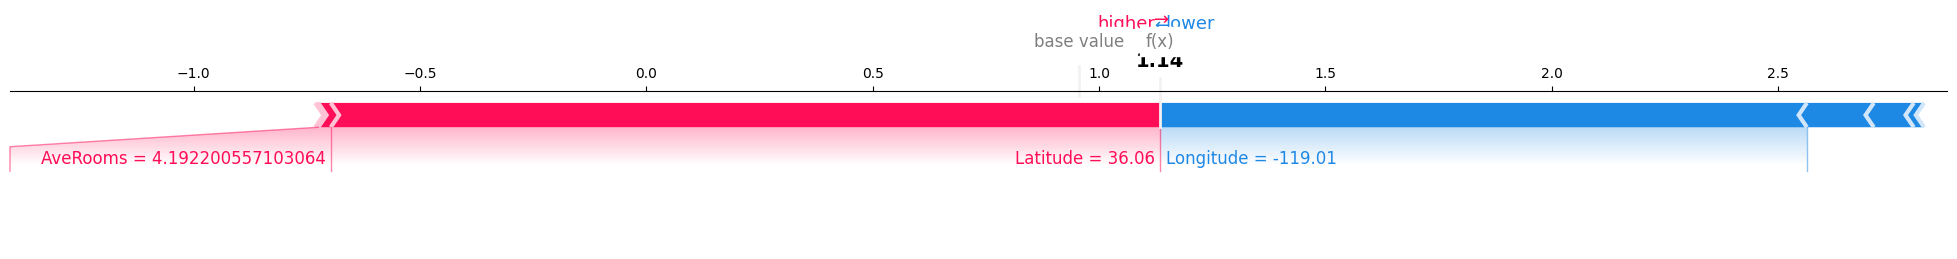

In [10]:
#force plot
out_file = str(OUTPUT_DIR / f"SHAP_{shap_type}_force_sample-{single_datapoint.index[0]}.png")
fig = shap.force_plot(explainer.expected_value, shap_values_single, X_test.iloc[ROW_INDEX,:], matplotlib=True, show=False)
plt.tight_layout()
fig.savefig(out_file, bbox_inches = 'tight', dpi=150)
plt.show()

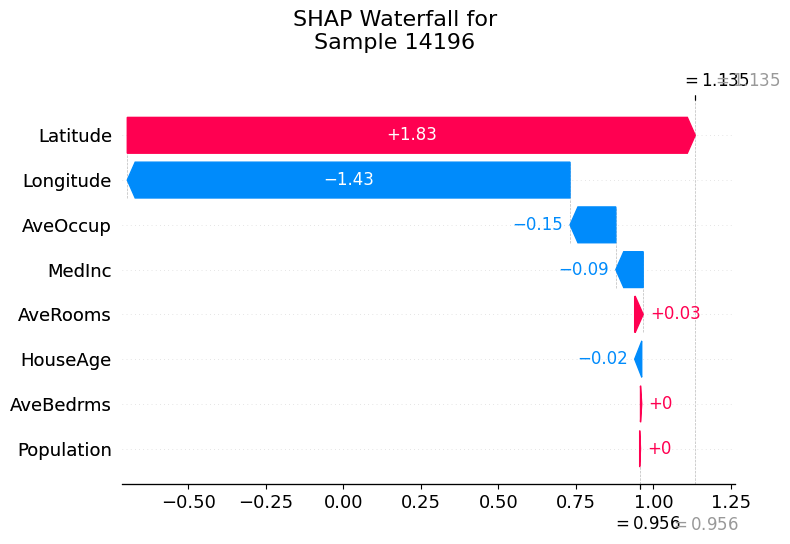

In [11]:
#waterfall
out_file = str(OUTPUT_DIR / f"{shap_type}_SHAP_waterfall_sample-{single_datapoint.index[0]}.png")
fig = shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_single[0], feature_names=single_datapoint.columns, show=False)
# fig.suptitle(f"SHAP Waterfall for {VU} Sample {single_datapoint.index[0]}", fontsize=16,)
fig.suptitle(
        f"SHAP Waterfall for\n"
        f"Sample {single_datapoint.index[0]}",
        fontsize=16,
    )
plt.tight_layout()
fig.savefig(out_file, bbox_inches = 'tight', dpi=150)
plt.show()

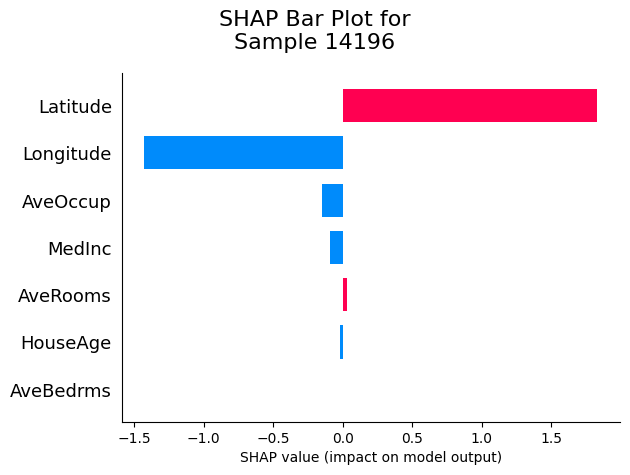

In [12]:
#bar plot
out_file = str(OUTPUT_DIR / f"{shap_type}_SHAP_bar_sample-{single_datapoint.index[0]}.png")
shap.bar_plot(shap_values_single[0], feature_names=single_datapoint.columns, show=False)    #this is a legacy version...
fig = plt.gcf()
# fig.suptitle(f"SHAP Bar Plot for {VU} Sample {single_datapoint.index[0]}", fontsize=16,)
fig.suptitle(
        f"SHAP Bar Plot for\n"
        f"Sample {single_datapoint.index[0]}",
        fontsize=16,
    )
plt.tight_layout()
fig.savefig(out_file, bbox_inches = 'tight', dpi=150)
plt.show()

In [13]:
#NOTE: this can take quite long time (~30min for 800 samples)
X_test_sub = X_test.sample(frac=0.2, random_state=_SEED)  #subset for less computation time
X_test_sub.shape
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values_sub = explainer.shap_values(X_test_sub, nsamples=NSHAP_SAMPLES)

fig = shap.force_plot(explainer.expected_value, shap_values_sub, X_test_sub, show=False)
shap.save_html(str(OUTPUT_DIR / f"{shap_type}_SHAP_force_{len(X_test_sub)}-inst.htm"), fig)
fig

  0%|          | 0/826 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X_test, show=False)
fig = plt.gcf()
plt.tight_layout()
fig.savefig(str(OUTPUT_DIR / f"{shap_type}_SHAP_summary_multi-inst.png"), bbox_inches = 'tight', dpi=150)